Optimal transport with primal-dual
-------
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\renewcommand{\div}{\operatorname{div}}$
$\newcommand{\prox}{\operatorname{prox}}$
$\newcommand{\proj}{\operatorname{proj}}$

In [1]:
from __future__ import division
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
from numpy import *
from numpy.fft import *
from numpy.random import *
from numpy.linalg import *
from scipy.misc import *
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import dctn,idctn
from scipy.sparse import diags
from numpy.matlib import repmat

import warnings
warnings.filterwarnings('ignore')


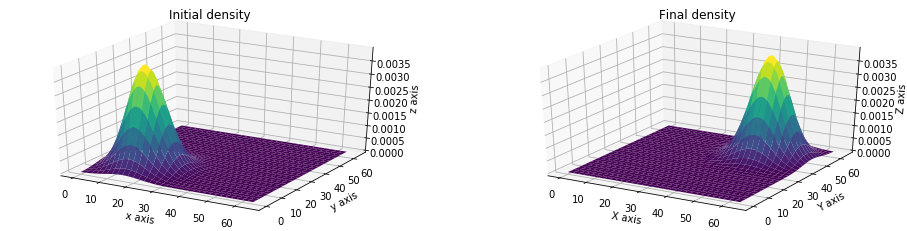

In [2]:
# grid size
Nx = 64;
N=Nx+1

#Create spatial grid
x = np.linspace(0,Nx,N)
gaussian = lambda a,b,sigma,x,y: exp( -((x-a)**2+(y-b)**2)/(2*sigma**2) )
normalize = lambda u: u/np.sum(u)
rho0 = lambda y,z: gaussian(0.25,0.25,0.1,y/Nx,z/Nx) 
rho1 = lambda y,z: gaussian(0.75,0.75,0.1,y/Nx,z/Nx)
[YY,ZZ]=meshgrid(x,x);
bcx0 = normalize(rho0(YY,ZZ)); BC0=bcx0[np.newaxis,:,:] 
bcx1 = normalize(rho1(YY,ZZ)); BC1=bcx1[np.newaxis,:,:]
#initialisation of rho to the linear interpolation
rho = np.zeros([N,N,N])
for i in range(N):
    rho[:,:,i]= (i*bcx1[:,:] + (N-i+1)*bcx0[:,:])/(N-1)
    
#Make a 3D plot
fig = plt.figure(figsize=plt.figaspect(0.25))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.plot_surface(YY, ZZ, bcx0,cmap='viridis',linewidth=0)
ax0.set_xlabel('x axis')
ax0.set_ylabel('y axis')
ax0.set_zlabel('z axis')
ax0.set_title('Initial density')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(YY, ZZ, bcx1,cmap='viridis',linewidth=0)
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')
ax1.set_title('Final density')
plt.show()


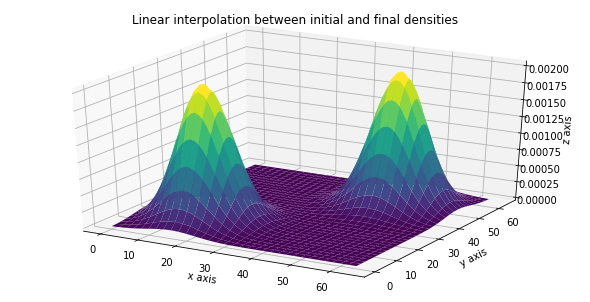

In [3]:
#plot the mean value in the L2 topology
rho_mean = rho[:,:,int(N/2)+1]
fig2=plt.figure(figsize=plt.figaspect(0.5))
ax2 = Axes3D(fig2)
ax2.plot_surface(YY, ZZ, rho_mean,cmap='viridis',linewidth=0)
ax2.set_xlabel('x axis')
ax2.set_ylabel('y axis')
ax2.set_zlabel('z axis')
ax2.set_title('Linear interpolation between initial and final densities')
plt.show()       

Projection on the paraboloid $a+\frac12|b|^2\le0$ in $\RR^3$. This is involved in the computation of some prox operator below.

In [4]:
# projK3d: projection on the paraboloid whose indicator function is the conjugate of the energy function of OT
def p13(x): return(np.sign(x)*(np.abs(x))**(1./3))
def projK2d(alpha,beta): 
    # compute the projection of (alpha,beta) onto the paraboloid a+0.5*b**2<=0
    # First work on the projection (a,b) of (alpha,|beta|) on the positive branch and adjust the sign of b accordingly
    # The Algorithm find the at most three points on the parabola from which the segments going through (alpha,|beta|)
    # is orthogonal to the parabola. Only the point with nonnegative b corresponds to the seeked projection.
    a = np.zeros(shape(alpha)); b = np.zeros(shape(beta)); nb = np.zeros(shape(beta))
    sgn = alpha+0.5*beta**2
    # if we are in the paraboloid, return input values
    a[sgn<=0] = alpha[sgn<=0]; b[sgn<=0] = beta[sgn<=0]
    # canonic form of order 3 polynomials (Cardano's method)
    p = 2*(alpha+1); q = -2*np.abs(beta); DELTA = q**2+4./27*p**3
    # if only one root, we got our guy
    ip = (sgn>0)&(DELTA>0)
    if (ip.any()):
        nb[ip] = p13((-q[ip]+np.sqrt(DELTA[ip]))/2)+p13((-q[ip]-np.sqrt(DELTA[ip]))/2)
        a[ip] = -(nb[ip]**2)/2
        b[ip] = np.sign(beta[ip]) * nb[ip]
    # if several roots, pick the one which is nonnegative (other(s) are intersection with negative branch of parabola)
    im = (sgn>0)&(DELTA<=0)
    if (im.any()):
        nb[im] = 2*np.sqrt(-p[im]/3) * np.cos(1./3*np.arccos(-(q[im]/2) * np.sqrt(-27./(p[im]**3))))
        imm = im&(nb<0)
        if (imm.any()):
            nb[imm]=2*np.sqrt(-p[imm]/3) * np.cos(1./3*np.arccos(-(q[imm]/2) * sqrt(-27./(p[imm]**3)))+2*np.pi/3)
            immm = im&(nb<0)
            if (immm.any()):
                nb[immm] = 2*np.sqrt(-p[immm]/3) * np.cos(1./3*np.arccos(-q[immm]/2 * np.sqrt(-27./(p[immm]**3)))+4*np.pi/3)
        a[im] = -(nb[im]**2)/2
        b[im] = np.sign(beta[im])*nb[im]
        test = (nb[im]<0)
        if (test.any()):
           warnings.warn("Abnormal case reached in projK2d") 
    return([a,b])
# 3D case : reconstruct 3D projection from axisymmmetric projection computed by projK2d
def projK3d(alpha,beta1,beta2):
    [a,b]=projK2d(alpha,sqrt(beta1**2+beta2**2));
    mu = alpha-a
    b1 = beta1 / (1+mu)
    b2 = beta2 / (1+mu)
    return([a,b1,b2])
def projK3dm(z):
    alpha = z[0,:,:,:]
    beta1 = z[1,:,:,:]
    beta2 = z[2,:,:,:]
    [a,b]=projK2d(alpha,sqrt(beta1**2+beta2**2));
    mu = alpha-a
    b1 = beta1 / (1+mu)
    b2 = beta2 / (1+mu)
    u=np.copy(z)
    u[0,:,:,:]=a
    u[1,:,:,:]=b1
    u[2,:,:,:]=b2
    return(u)

Expression of divergence, gradient and curl operator as second order centered finite difference up to the boundary. This operators verify div(curl)=0 and curl(grad)=0 at the discrete level up to machine precision.

In [5]:
#Differential operators
def mydiv(v):
    [d,Nx,Ny,Nt]=shape(v)
    dv = np.zeros([Nx,Ny,Nt])
    dv[0,:,:] = -0.5*v[0,2,:,:]+2.*v[0,1,:,:]-1.5*v[0,0,:,:]
    dv[1:Nx-1,:,:] = (v[0,2:Nx,:,:]-v[0,0:Nx-2,:,:])/2
    dv[Nx-1,:,:] = 1.5*v[0,Nx-1,:,:]-2*v[0,Nx-2,:,:]+0.5*v[0,Nx-3,:,:]
    dv[:,0,:] =  dv[:,0,:] -0.5*v[1,:,2,:]+2.*v[1,:,1,:]-1.5*v[1,:,0,:]
    dv[:,1:Ny-1,:] =  dv[:,1:Ny-1,:] + (v[1,:,2:Ny,:]-v[1,:,0:Ny-2,:])/2
    dv[:,Ny-1,:] = dv[:,Ny-1,:] + 1.5*v[1,:,Ny-1,:]-2*v[1,:,Ny-2,:]+0.5*v[1,:,Ny-3,:]
    dv[:,:,0] =  dv[:,:,0] - 0.5*v[2,:,:,2]+2.*v[2,:,:,1]-1.5*v[2,:,:,0]
    dv[:,:,1:Nt-1] =  dv[:,:,1:Nt-1] + (v[2,:,:,2:Nt]-v[2,:,:,0:Nt-2])/2
    dv[:,:,Nt-1] =  dv[:,:,Nt-1] + 1.5*v[2,:,:,Nt-1]-2*v[2,:,:,Nt-2]+0.5*v[2,:,:,Nt-3]
    return(dv)

def mygrad(h):
    [Nx,Ny,Nt]=shape(h)
    grh = np.zeros([3,Nx,Ny,Nt])
    grh[0,0,:,:] = -0.5*h[2,:,:]+2.*h[1,:,:]-1.5*h[0,:,:]
    grh[0,1:Nx-1,:,:] = (h[2:Nx,:,:]-h[0:Nx-2,:,:])/2.
    grh[0,Nx-1,:,:] = 1.5*h[Nx-1,:,:]-2*h[Nx-2,:,:]+0.5*h[Nx-3,:,:]
    
    grh[1,:,0,:] = -0.5*h[:,2,:]+2.*h[:,1,:]-1.5*h[:,0,:]
    grh[1,:,1:Nx-1,:] = (h[:,2:Ny,:]-h[:,0:Ny-2,:])/2.
    grh[1,:,Nx-1,:] = 1.5*h[:,Nx-1,:]-2*h[:,Nx-2,:]+0.5*h[:,Nx-3,:]
    
    grh[2,:,:,0] = -0.5*h[:,:,2]+2.*h[:,:,1]-1.5*h[:,:,0]
    grh[2,:,:,1:Nt-1] = (h[:,:,2:Nt]-h[:,:,0:Nt-2])/2.
    grh[2,:,:,Nt-1] = 1.5*h[:,:,Nt-1]-2*h[:,:,Nt-2]+0.5*h[:,:,Nt-3]
    return(grh)

def mycurl(V):
    [d,Nx,Ny,Nt]=shape(V)
    cv = np.zeros([d,Nx,Ny,Nt])
    cv[0,:,0,:] = -0.5*V[2,:,2,:]+2*V[2,:,1,:]-1.5*V[2,:,0,:]
    cv[0,:,1:Ny-1,:] = (V[2,:,2:Ny,:]-V[2,:,0:Ny-2,:])/2
    cv[0,:,Ny-1,:] = 0.5*V[2,:,Ny-3,:]-2*V[2,:,Ny-2,:]+1.5*V[2,:,Ny-1,:]
    cv[0,:,:,0] = cv[0,:,:,0] - (-0.5*V[1,:,:,2]+2*V[1,:,:,1]-1.5*V[1,:,:,0])
    cv[0,:,:,1:Nt-1] = cv[0,:,:,1:Nt-1] - (V[1,:,:,2:Nt]-V[1,:,:,0:Nt-2])/2
    cv[0,:,:,Nt-1] = cv[0,:,:,Nt-1] - (0.5*V[1,:,:,Nt-3]-2*V[1,:,:,Nt-2]+1.5*V[1,:,:,Nt-1])
    
    
    cv[1,:,:,0] = -0.5*V[0,:,:,2]+2*V[0,:,:,1]-1.5*V[0,:,:,0];
    cv[1,:,:,1:Nt-1] = (V[0,:,:,2:Nt]-V[0,:,:,0:Nt-2])/2
    cv[1,:,:,Nt-1] = 0.5*V[0,:,:,Nt-3]-2*V[0,:,:,Nt-2]+1.5*V[0,:,:,Nt-1]
    cv[1,0,:,:] = cv[1,0,:,:] - (-0.5*V[2,2,:,:]+2*V[2,1,:,:]-1.5*V[2,0,:,:])
    cv[1,1:Nx-1,:,:] = cv[1,1:Nx-1,:,:] - (V[2,2:Nx,:,:]-V[2,0:Nx-2,:,:])/2
    cv[1,Nx-1,:,:] = cv[1,Nx-1,:,:] - (0.5*V[2,Nx-3,:,:]-2*V[2,Nx-2,:,:]+1.5*V[2,Nx-1,:,:])
    
    cv[2,0,:,:] = -0.5*V[1,2,:,:]+2*V[1,1,:,:]-1.5*V[1,0,:,:]
    cv[2,1:Nx-1,:,:] = (V[1,2:Nx,:,:]-V[1,0:Nx-2,:,:])/2
    cv[2,Nx-1,:,:] = 0.5*V[1,Nx-3,:,:]-2*V[1,Nx-2,:,:]+1.5*V[1,Nx-1,:,:]
    cv[2,:,0,:] = cv[2,:,0,:] - (-0.5*V[0,:,2,:]+2*V[0,:,1,:]-1.5*V[0,:,0,:])
    cv[2,:,1:Ny-1,:] = cv[2,:,1:Ny-1,:] - (V[0,:,2:Ny,:]-V[0,:,0:Ny-2,:])/2
    cv[2,:,Ny-1,:] = cv[2,:,Ny-1,:] - (0.5*V[0,:,Ny-3,:]-2*V[0,:,Ny-2,:]+1.5*V[0,:,Ny-1,:])
    return(cv)

#test if mydiv(myvurl)=0  ---> 1.3322676295501878e-15
vv=np.random.rand(3,10,10,10)
np.max(np.abs(mydiv(mycurl(vv))))
# test if mycurl(mygrad)=0 --> 8.881784197001252e-16
#hh=np.random.rand(20,20,20)
#np.max(np.abs(mycurl(mygrad(hh))))

2.220446049250313e-15

In [6]:
def poisson3dN(f,lx,ly,lz):
    [nx,ny,nz] = shape(f)
    hx = lx/nx; hy = ly/ny; hz = lz/nz;
    dnx = np.linspace(0,nx-1,nx); dny = np.linspace(0,ny-1,ny); dnz = np.linspace(0,nz-1,nz);
    depnx = 2*np.cos(np.pi*dnx/nx)-2; depny = 2*np.cos(np.pi*dny/ny)-2; depnz = 2*np.cos(np.pi*dnz/nz)-2;
    denom = tile(depnx[:,np.newaxis,np.newaxis]/hx**2,(1,ny,nz)) + tile(depny[np.newaxis,:,np.newaxis]/hy**2,(nx,1,nz)) + tile(depnz[np.newaxis,np.newaxis,:]/hz**2,(nx,ny,1));
    denom[denom==0]=1
    fhat = dctn(f,norm='ortho')
    uhat = -fhat/denom
    res = idctn(uhat,norm='ortho')
    return(res)

Solve the minimization problem written in the space of constraint using Helmholtz-Hodge decomposition. This amounts to look, for $J(\rho,m)=\frac{m^2}{2\rho}$ to a minimum of
$$\min_{(\rho,m)\in C}\int_0^1\int_\Om J(\rho,m) dxdt\qquad\text{where }C=\left\{(\rho,m),\partial_t\rho+\div_x m=0,\;(\rho,m)\cdot N_{x,t}=g_{01}(x,t)\text{ on }\partial(\Om\times(0,T))\right\}.$$
The function $g_{01}(x,t)$ carries boundary conditions: $\rho_0$ on $\Om\times\{0\}$, $\rho_1$ on $\Om\times\{1\}$, and $0$ on $\partial\Om\times(0,T)$. In our formulation we search for $(\rho,m)$ under the form 
$$(\rho,m)=\nabla\times\phi+\nabla h$$
where $\phi$ is a vector field with homogeneous boundary conditions, and $h$ a scalar field such that
$$\begin{cases}
-\Delta h=0&\in\Om\times(0,T)\\
\partial_N h= g_{01}(x,t)
\end{cases}$$
First let us compute $h$:

In [8]:
# Raising of boundary conditions    
u3Dbc = np.concatenate((-BC0,np.zeros((N-2,N,N)),BC1),axis=0);
h=poisson3dN(u3Dbc,Nx,Nx,Nx);
gradh=mygrad(h)

from mayavi import mlab
mlab.contour3d(gradh[0,:,:,:],contours=25, transparent=True)
mlab.axes(xlabel='X',ylabel='Y',zlabel='Z')
mlab.outline()
mlab.show()

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



Given $h$, the minimization problems boils down to:
$$\min_{\phi\in C_0}J_h(\nabla\times\phi)$$
where $J_h(v)=J(v+\nabla h)$ and $C_0$ is merely the zero boundary conditions. Its primal-dual formulation is 
$$\min_{\phi}\max_Z\left<\nabla\times\phi,Z\right>-J_h^*(Z)+\chi_{C_0}(\phi)$$
and the Chambolle-Pock algorithm reads (for $\theta=0$)
$$\begin{cases}
Z^{n+1}=\prox_{\sigma J_h^*}(Z^n+\sigma \nabla\times\phi^n)&\\
\phi^{n+1}=\prox_{C_0}(\phi^{n}-\tau\nabla\times Z^{n+1})
\end{cases}$$
where $\prox_{C_0}$ is the projection on zero boundary conditions, and $\prox_{\sigma J_h^*}(x)=\prox_{\sigma J^*}(x+\sigma\nabla h)=\proj_K(x+\sigma\nabla h)$.

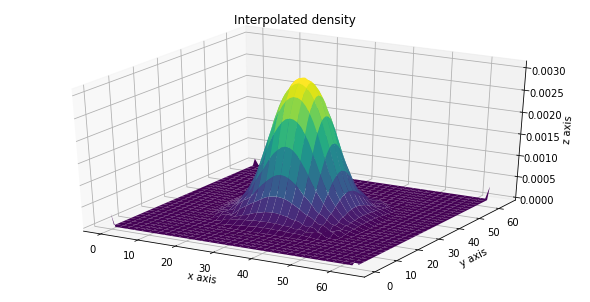

In [9]:
#initiatilization of m and a,b to 0
phi = np.zeros([3,N,N,N])
z = np.zeros([3,N,N,N])
phit = np.copy(phi)
# iteration of Primal-dual
itmax=1000; sig = 65; L = 4; tau = 0.99/(sig*L); theta=1;

for it in range(0,itmax):
    phim1 = np.copy(phi)
    z = projK3dm(z+sig*(mycurl(phit)+gradh))
    phi = phi - tau*mycurl(z)
    phi[:,0,:,:]=0; phi[:,N-1,:,:]=0
    phi[:,:,0,:]=0; phi[:,:,N-1,:]=0
    phi[:,:,:,0]=0; phi[:,:,:,N-1]=0
    phit=(1+theta)*phi-theta*phim1;

# plot the solution at t=1/2 which is the Wassertein average of rho0 and rho1
rhom=mycurl(phi)+gradh;
fig3=plt.figure(figsize=plt.figaspect(0.5))
ax3 = Axes3D(fig3)
ax3.plot_surface(YY, ZZ, rhom[0,int(N/2),:,:],cmap='viridis',linewidth=0)
ax3.set_xlabel('x axis')
ax3.set_ylabel('y axis')
ax3.set_zlabel('z axis')
ax3.set_title('Interpolated density')
plt.show()       

In [ ]:
from mayavi import mlab
mlab.contour3d(rhom[0,:,:,:],contours=25, transparent=True)
mlab.axes(xlabel='X',ylabel='Y',zlabel='Z')
mlab.outline()
mlab.show()
